In [1]:
# Importing the necessary libraries
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.tools.jupyter import *
from qiskit.visualization import *


C:\Users\Shaurya\anaconda3\envs\QiskitEnv\lib\site-packages\requests_ntlm\requests_ntlm.py:5: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography import x509


In [2]:
# Define projectors.
# Note that p_left is actually p_right from above because the order
# of operations are reversed when equations are turned into circuits
# due to how time-flow is defined in circuit structures

# In the Qiskit implementation qubit indexes start from 0
# and the most significant qubit is the highest index
# keeping this in mind e.g for 4 nqubits = {q0,q1,q2,q3}
# q0 and q1 are the system qubits
# q2 is the signal qubit
# q3 is the ancillary rotation qubit
# nqubits-1 = 4-1 = 3 below, then corresponds to q3

def p_left(q, phi): #right projector
    qc = QuantumCircuit(q)
    n = q
    ctrl_range = list(range(0,n-1))
    
    for qubit in range(n-1): # Implement a simple multi 0-controlled
        qc.x(qubit)
    qc.mcx(ctrl_range , n-1) # 0-Controlled on all but the last qubits, acts on the last qubit
    for qubit in range(n-1):
        qc.x(qubit)
        
    #qc.barrier(0, 1, 2, 3)
    qc.rz(phi, n-1) # RZ(phi) on the last qubit
    #qc.barrier(0, 1, 2, 3)
    
    for qubit in range(n-1): # Reverse the effect of the first multi-control
        qc.x(qubit)
    qc.mcx(ctrl_range ,n-1) 
    for qubit in range(n-1):
        qc.x(qubit)
    
    p_left_gate = qc.to_gate() # Compiles all this into a gate
    p_left_gate.name = "P$_l$(Φ)"
    return p_left_gate

def p_right(phi): # Left projector acts just on the signal and the ancillary qubit
    qc = QuantumCircuit(2)
    
    qc.cx(0, 1)
    qc.rz(phi, 1)
    qc.cx(0 ,1)
    
    p_right_gate = qc.to_gate()
    p_right_gate.name = "P$_r$(Φ)"
    return p_right_gate


In [3]:
#Define Oracle and the reverse-gate for 
#constructing the dagger later

def U(q): 
    qc = QuantumCircuit(q)
    n = q + 1
    
    for qubit in range(n-2):
        qc.h(qubit)
    
    qc.mcx(list(range(0,n-2)), n-2)
    
    U_gate = qc.to_gate()
    U_gate.name = "U"
    return U_gate

def reverse_gate(gate):
    gate_rev = gate.reverse_ops()
    gate_rev.name = gate.name + "$^†$"
    return gate_rev


In [4]:

def qsvt_search(target): # target = marked element, is a bit-string!
    
    systemqubits = len(target)
    nqubits = systemqubits + 2
    q = QuantumRegister(nqubits, 'q')
    circuit = QuantumCircuit(q)  

    d = (2*systemqubits) - 1
    
    if systemqubits > 6 and systemqubits < 10:
        for i in range(1, systemqubits - 6 + 1):
            d += 2 * i
    
    u = U(nqubits-1)
    u_dag = reverse_gate(u)
    
    p_right_range = [nqubits-2, nqubits-1]
    u_range = list(range(0, nqubits-1))
    p_left_range = list(range(0, nqubits))

    circuit.append(p_left(nqubits,(1-d)*pi), p_left_range)
    circuit.append(U(nqubits-1), u_range)

    for i in range((d-1)//2):
        circuit.append(p_right(pi), p_right_range) #debug this, doesnt work just as a 2 qubit gate
        circuit.append(u_dag, u_range)
        circuit.append(p_left(nqubits,pi), p_left_range)
        circuit.append(u, u_range)

    for i in range(len(target)): # The operation for acquiring arbitrary marked element
        bts = target [::-1]      # bitstring is reversed to be compatible with the reverse qubit order in Qiskit
        if bts[i] == '0':
            circuit.x(i)

    circuit.measure_all()
    return circuit

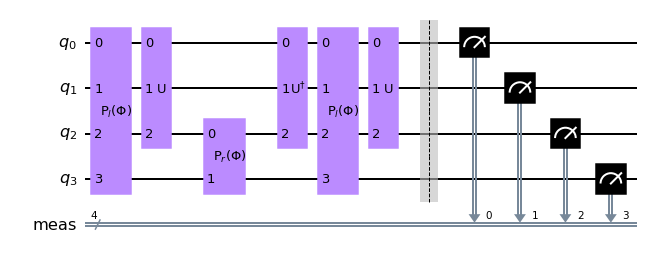

In [5]:
circuit_test = qsvt_search('11')
circuit_test.draw('mpl')


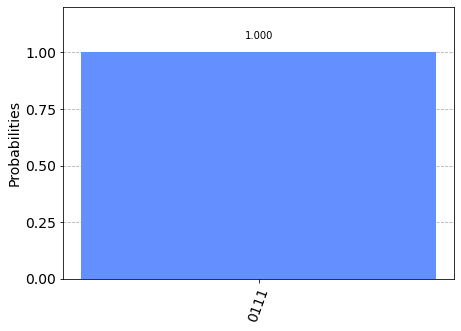

In [6]:
# qasm_sim = Aer.get_backend('qasm_simulator')
# transpiled_circuit = transpile(circuit, qasm_sim)
# qobj = assemble(transpiled_circuit)
# results = qasm_sim.run(qobj).result()
# counts = results.get_counts()
# plot_histogram(counts)


backend = Aer.get_backend("aer_simulator")
tqc = transpile(circuit_test, backend)
job = backend.run(tqc, shots=1000)
result = job.result()
counts = result.get_counts(tqc)

plot_histogram(counts)


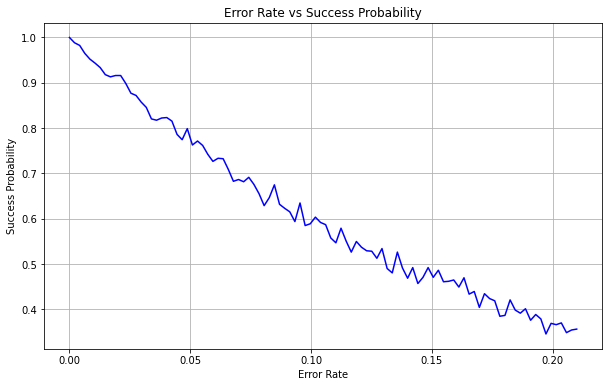

In [8]:
from qiskit import QuantumCircuit, execute, Aer
import qiskit.providers.aer.noise as noise
import matplotlib.pyplot as plt

# Define the Grover circuit (adjust accordingly)
a=np.linspace(0,21,100)

# Noiseless simulation for baseline
simulator = Aer.get_backend('qasm_simulator')
ideal_result = execute(circuit_test, simulator, shots=1024).result()
ideal_counts = ideal_result.get_counts()

# Assume the correct result is the most frequent result in the ideal case
correct_result = max(ideal_counts, key=ideal_counts.get)

# Error rates
error_rates = [0.01 * i for i in a]  # from 1% to 25%

# List to store success probabilities
success_probabilities = []

for prob in error_rates:
    # Define depolarizing errors for both 1-qubit and 2-qubit gates
    error_1 = noise.depolarizing_error(prob, 1)
    error_2 = noise.depolarizing_error(prob, 2)

    # Create a noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

    # Simulate with noise
    result = execute(circuit_test, simulator, noise_model=noise_model, shots=1024).result()
    counts = result.get_counts()

    # Calculate success probability
    success_probability = counts.get(correct_result, 0) / 1024
    success_probabilities.append(success_probability)

# Plotting error rate vs success probability
plt.figure(figsize=(10, 6))
plt.plot(error_rates, success_probabilities, linestyle='-', color='b')
plt.title('Error Rate vs Success Probability')
plt.xlabel('Error Rate')
plt.ylabel('Success Probability')
plt.grid(True)
plt.show()

In [10]:
suc=success_probabilities
suc

[1.0,
 0.98828125,
 0.982421875,
 0.96484375,
 0.9521484375,
 0.943359375,
 0.93359375,
 0.91796875,
 0.9130859375,
 0.916015625,
 0.916015625,
 0.8984375,
 0.876953125,
 0.8720703125,
 0.857421875,
 0.845703125,
 0.8203125,
 0.8173828125,
 0.822265625,
 0.8232421875,
 0.8154296875,
 0.7861328125,
 0.7744140625,
 0.798828125,
 0.7626953125,
 0.771484375,
 0.76171875,
 0.7421875,
 0.7265625,
 0.7333984375,
 0.732421875,
 0.708984375,
 0.6826171875,
 0.6865234375,
 0.681640625,
 0.69140625,
 0.67578125,
 0.6552734375,
 0.62890625,
 0.646484375,
 0.6748046875,
 0.6318359375,
 0.623046875,
 0.615234375,
 0.59375,
 0.634765625,
 0.5849609375,
 0.5888671875,
 0.603515625,
 0.591796875,
 0.5869140625,
 0.5576171875,
 0.546875,
 0.5791015625,
 0.55078125,
 0.5263671875,
 0.5498046875,
 0.537109375,
 0.529296875,
 0.5283203125,
 0.5126953125,
 0.5341796875,
 0.490234375,
 0.48046875,
 0.5263671875,
 0.4912109375,
 0.46875,
 0.4921875,
 0.45703125,
 0.470703125,
 0.4921875,
 0.470703125,
 0.4863

In [7]:
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


# Thermal noisy simulation
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])


In [8]:
sim_thermal = AerSimulator(noise_model=noise_thermal)


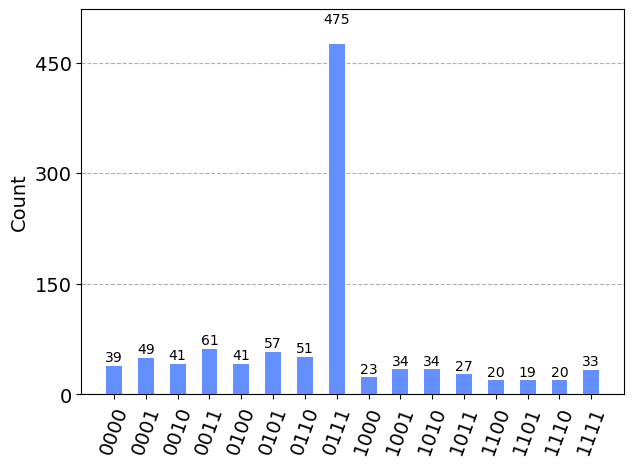

In [9]:
circ_tthermal = transpile(circuit_test, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)




{'110': 498, '101': 526}


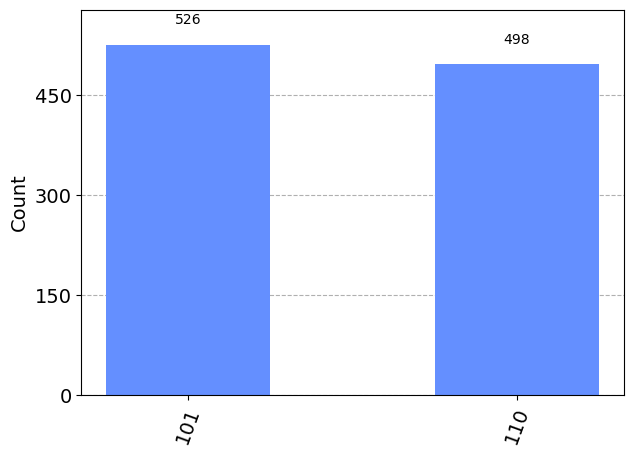

In [11]:
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

qr = QuantumRegister(3)  # Initialize qubits
cr = ClassicalRegister(3)  # Initialize bits for record measurements
circuit = QuantumCircuit(qr, cr)

# We want to search two marked states
# |101> and |110>

# Apply Hadamard to all qubits
circuit.h(qr)
circuit.barrier()

# Phase oracle (Marks states |101> and |110> as results)
circuit.cz(qr[2], qr[0])
circuit.cz(qr[2], qr[1])

# Inversion around the average
circuit.h(qr)
circuit.x(qr)
circuit.barrier()
circuit.h(qr[2])
circuit.ccx(qr[0], qr[1], qr[2])
circuit.h(qr[2])
circuit.barrier()
circuit.x(qr)
circuit.h(qr)

# Measure
circuit.measure(qr, cr)

# Run our circuit with local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)
plot_histogram(answer)


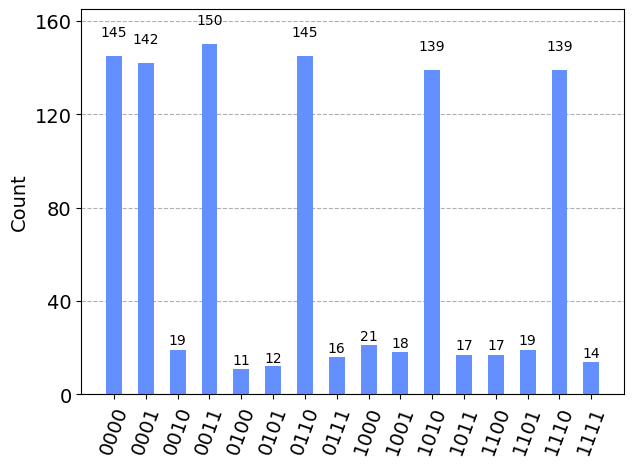

In [13]:
from qiskit import QuantumCircuit, transpile, Aer, assemble
from qiskit.visualization import plot_histogram

# Define the Grover circuit
def grover_circuit():
    n = 4  # Number of qubits
    grover_circ = QuantumCircuit(n, n)

    # Apply Hadamard gate to all qubits
    grover_circ.h(range(n))

    # Oracle for the marked element |1101>
    grover_circ.x([0, 2, 3])  # Flip the corresponding qubits to mark |1101>
    grover_circ.cz(0, 1)
    grover_circ.cz(2, 3)
    grover_circ.x([0, 2, 3])  # Undo the changes

    # Diffusion operator
    grover_circ.h(range(n))
    grover_circ.x(range(n))
    grover_circ.h(n-1)
    grover_circ.mct(list(range(n-1)), n-1)
    grover_circ.h(n-1)
    grover_circ.x(range(n))
    grover_circ.h(range(n))

    # Measure qubits
    grover_circ.measure(range(n), range(n))

    return grover_circ

# Transpile the circuit for simulator
grover_circuit = transpile(grover_circuit(), Aer.get_backend('qasm_simulator'))

# Run on simulator
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(grover_circuit).result()

# Plot histogram
counts = result.get_counts()
plot_histogram(counts)
